## Import libarary yang dibutuhkn

In [ ]:
!pip install Sastrawi
!pip install tensorflow
!pip install swifter
!pip install transformers
!pip install textblob
!pip install vaderSentiment

Could not strip 'notebook_pelatihan_model.ipynb': file not found


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import seaborn as sns
from sklearn.svm import SVC
import swifter
from tqdm import tqdm
from joblib import Parallel, delayed
from textblob import TextBlob
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Memuat Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Dataset hasil scraping dengan ulasan_aplikasi_twitter.csv')

Mounted at /content/drive


# Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,userName,Rating,Review,Tanggal
0,Pengguna Google,2,"Banyak bug, jadi lemot (foto atau video sering...",2025-03-11 15:06:40
1,Pengguna Google,1,"Saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48
2,Pengguna Google,1,"semenjak jadi X malah lemot, minta update seri...",2025-02-04 22:06:28
3,Pengguna Google,4,Kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01
4,Pengguna Google,5,"Untuk pihak X, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11111 entries, 0 to 11110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  11111 non-null  object
 1   Rating    11111 non-null  int64 
 2   Review    11111 non-null  object
 3   Tanggal   11111 non-null  object
dtypes: int64(1), object(3)
memory usage: 347.3+ KB


dari dataframe diatas terdapat 11110 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [ ]:
df['Rating'].value_counts()
df['userName'].nunique()

1

 Melihat jumlah kemunculan tiap nilai di kolom Rating

In [ ]:
df.shape

(11111, 4)

In [ ]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(11110)

In [ ]:
df.describe(include='all')

,userName,Rating,Review,Tanggal
count,11111,11111.000000,11111,11111
unique,1,NaN,11101,11107
top,Pengguna Google,NaN,Sangat membantu,2025-03-11 10:43:31
freq,11111,NaN,3,2
mean,NaN,1.988480,NaN,NaN
std,NaN,1.433322,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,1.000000,NaN,NaN
50%,NaN,1.000000,NaN,NaN
75%,NaN,3.000000,NaN,NaN


1. userName
Jumlah total: 11.111

Unik: 1

Nilai paling umum: "Pengguna Google" (muncul di semua baris)

Insight:

Semua nama pengguna disamarkan.

Kolom userName tidak informatif untuk analisis, bisa diabaikan atau dibuang.

2. Rating
Tipe data: Numerik

Statistik:

Rata-rata (mean): 1.99

Standar deviasi: 1.43

Minimum: 1

Kuartil 25%: 1

Median (50%): 1

Kuartil 75%: 3

Maksimum: 5

Insight:

Distribusi rating berat ke arah negatif.

Median = 1 → lebih dari setengah user memberi bintang 1.

Hanya sebagian kecil yang memberi bintang 4–5.

3. Review
Jumlah total review: 11.111

Jumlah unik: 11.101

Review paling sering muncul: "Sangat membantu" (muncul 3 kali)

Insight:

Hampir semua review berbeda → sangat beragam.

Duplikasi sangat kecil (hanya 10 duplikat dari 11.111 data), bisa diabaikan atau dibersihkan jika perlu.

4. Tanggal
Jumlah tanggal unik: 11.107

Tanggal paling sering muncul: 2025-03-11 10:43:31 (muncul 2 kali)

Insight:

Data dikumpulkan dalam waktu yang cukup variatif.

Distribusi waktu cukup baik, tidak terfokus di satu hari.

 Kesimpulan EDA (Dataset 11.111 Review):
Sentimen pengguna cenderung negatif, mayoritas rating bintang 1.

Review sangat beragam dan organik.

Data waktu dan review cukup menyebar → bagus untuk analisis lanjutan seperti time-series atau tren.

Kolom userName bisa diabaikan karena tidak memberikan informasi tambahan.



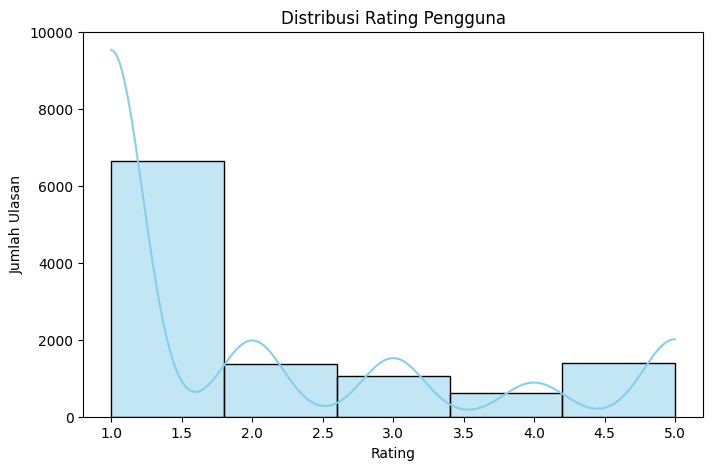

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

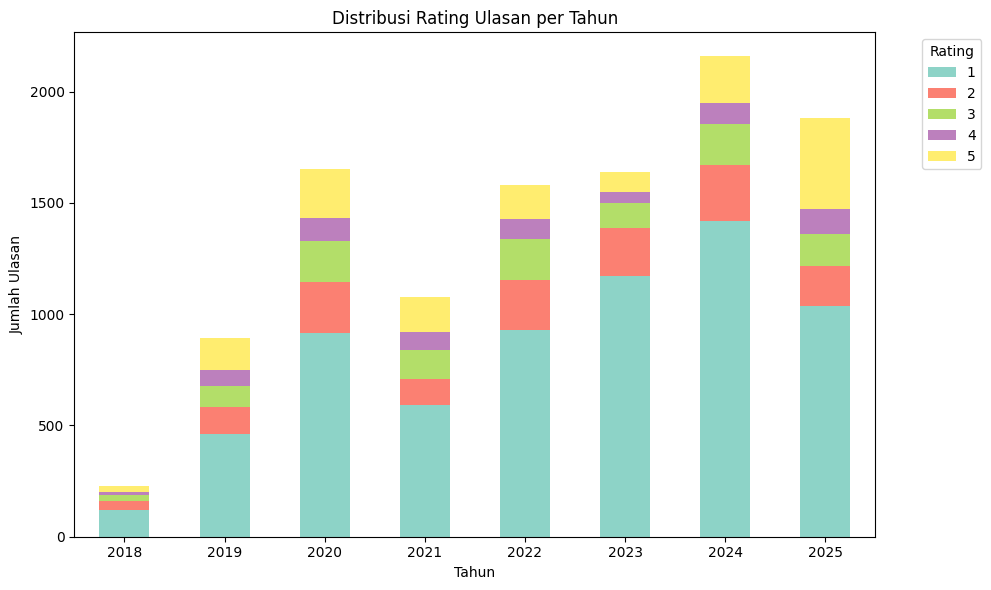

In [ ]:
# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

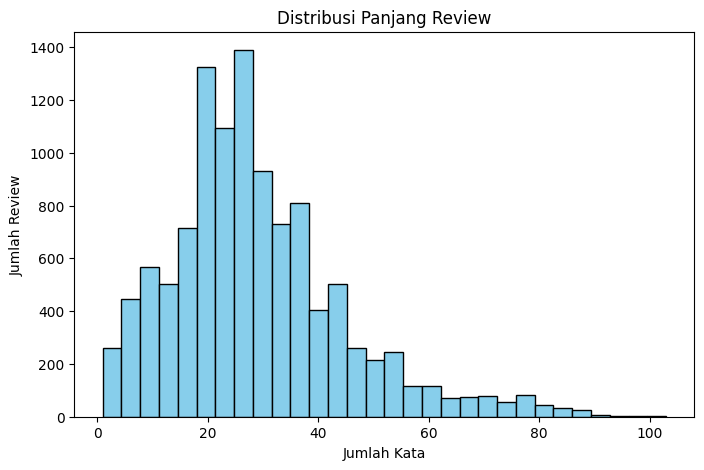

In [ ]:
# --- EDA: Distribusi Panjang Teks ---
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()


dari hasil visualisasi panjang pesan review user yang paling banayak ada di 25 untuk panjang kata 60-100 hanya sedikit

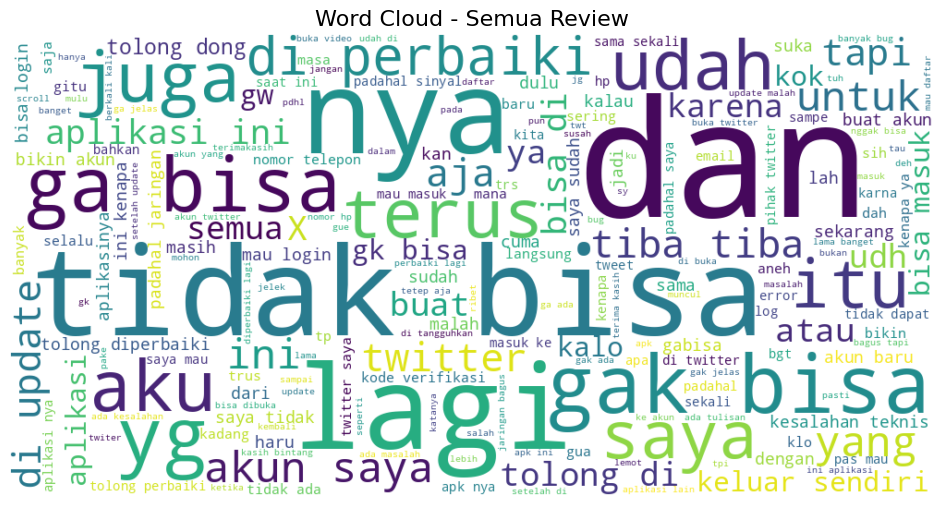

In [ ]:
# Gabungkan semua teks review
text_all = ' '.join(df['Review'].astype(str))

# Buat Word Cloud
wordcloud_all = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_all)

# Tampilkan Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review", fontsize=16)
plt.show()


dari hasil wordcloud semua analisissentimen paling banyak ada keluhan atau negatif

#  Pra-pemrosesan Teks

In [ ]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [ ]:
#Remove Special Characters, Angka, dan Punctuation
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

Buang simbol, angka, dan tanda baca yang nggak penting.

In [ ]:
#Tokenizing
df['tokens'] = df['Review'].apply(word_tokenize)

memecah kalimat menjadi potongan-potongan kata

In [ ]:
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

Menghapus stopwords, yaitu kata-kata umum yang sering muncul tapi nggak punya makna penting dalam analisis

In [ ]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Parallel stemming
def stem_word(word):
    return word, stemmer.stem(word)

all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))
stemmed_list = Parallel(n_jobs=-1)(delayed(stem_word)(word) for word in tqdm(unique_words))
stemmed_dict = dict(stemmed_list)

df['tokens'] = df['tokens'].swifter.apply(lambda x: [stemmed_dict[word] for word in x])


100%|██████████| 15718/15718 [15:57<00:00, 16.41it/s]


Pandas Apply:   0%|          | 0/11111 [00:00<?, ?it/s]

Melakukan stemming (mengubah kata ke bentuk dasar) terhadap token (kata-kata hasil tokenisasi) dari setiap dokumen dalam DataFrame df, secara efisien dan paralel.



In [ ]:
df

,userName,Rating,Review,Tanggal,review_length,tokens
0,Pengguna Google,2,banyak bug jadi lemot foto atau video sering n...,2025-03-11 15:06:40,34,"[bug, lot, foto, video, nggak, munculnggak, pu..."
1,Pengguna Google,1,saya baru instal lagi x ini mau login eh memua...,2025-03-10 14:18:48,37,"[instal, x, login, eh, muat, udh, tunggu, meni..."
2,Pengguna Google,1,semenjak jadi x malah lemot minta update serin...,2025-02-04 22:06:28,38,"[semenjak, x, lot, update, aplikasi, ga, baik,..."
3,Pengguna Google,4,kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01,46,"[video, masalah, lot, wifi, lancar, tolong, ba..."
4,Pengguna Google,5,untuk pihak x mohon tambahkan fitur juga bisa ...,2025-03-04 18:53:12,34,"[x, mohon, tambah, fitur, mati, kolom, quote, ..."
...,...,...,...,...,...,...
11106,Pengguna Google,2,gw edit again sih dri bintang ke bintang loa...,2022-09-03 14:51:34,30,"[gw, edit, again, sih, dri, bintang, bintang, ..."
11107,Pengguna Google,1,aplikasi apaan si twitter tolong ya perbaikin...,2021-04-11 18:09:53,28,"[aplikasi, si, twitter, tolong, ya, perbaikin,..."
11108,Pengguna Google,1,apk ngenod udh daftar berulang kli tetep aja g...,2021-04-06 00:38:58,24,"[apk, ngenod, udh, daftar, ulang, kli, tetep, ..."
11109,Pengguna Google,1,please lagi dan lagi gak bisa bukamemuat foto ...,2023-05-17 06:47:52,19,"[please, gak, bukamemuat, foto, or, video, udh..."


bertujuan untuk melakukan proses stemming secara efisien pada data token dalam Bahasa Indonesia. Pertama, semua kata dari token di setiap review dikumpulkan menjadi satu list besar (all_words), kemudian diubah menjadi kumpulan kata unik (unique_words) agar tidak melakukan stemming berulang-ulang untuk kata yang sama. Selanjutnya, dibuat kamus stemming (stemmed_dict) dengan menggunakan Sastrawi Stemmer yang memetakan setiap kata unik ke bentuk dasarnya. Terakhir, setiap token dalam kolom df['tokens'] diganti dengan hasil stemming yang diambil dari kamus tersebut. Teknik ini membantu mempercepat proses stemming dan menjaga konsistensi hasil stemming di seluruh dataset.

# ekstraksi fitur dan pelabelan data

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def label_textblob(polarity):
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

def label_vader(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'


In [ ]:
# Gabungkan token ke bentuk string
df['cleaned_review'] = df['tokens'].apply(lambda x: ' '.join(x))

# Hitung skor sentimen
df['vader_compound'] = df['cleaned_review'].apply(get_vader_sentiment)

# Labelkan skor compound
df['vader_label'] = df['vader_compound'].apply(label_vader)

# Encode label (hasil: 0,1,2)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['vader_label'])


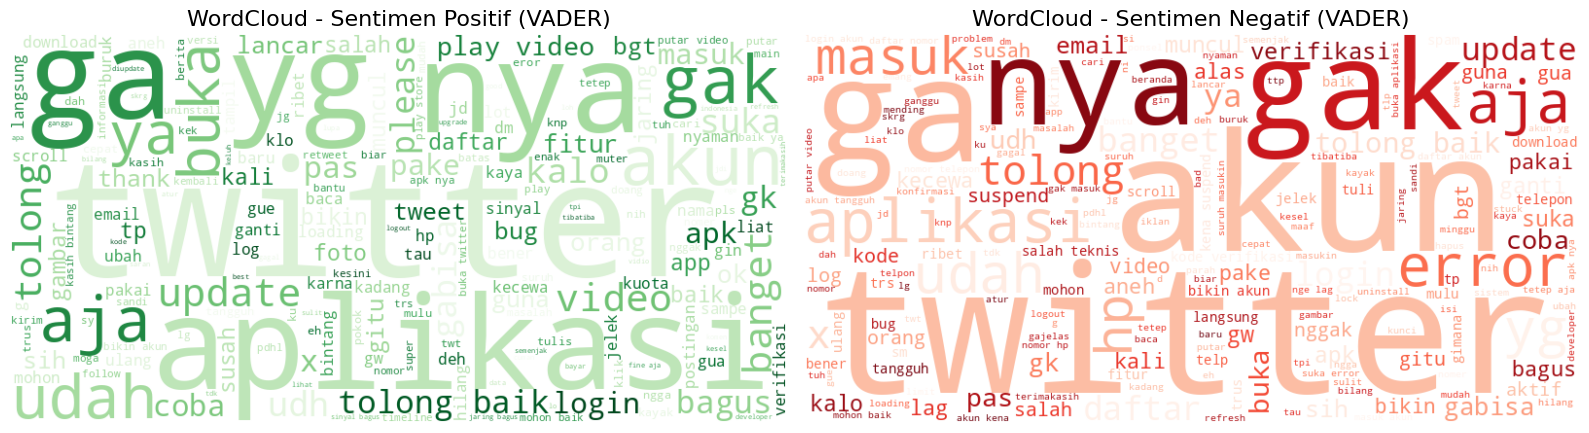

In [ ]:
# Filter data berdasarkan label sentimen
positif_text = ' '.join(df[df['vader_label'] == 'positif']['cleaned_review'])
negatif_text = ' '.join(df[df['vader_label'] == 'negatif']['cleaned_review'])

# Buat WordCloud untuk masing-masing sentimen
wordcloud_positif = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negatif_text)

# Plot WordCloud
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Positif (VADER)', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Negatif (VADER)', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

# modeling

##  SKEMA PELATIHAN 1: LSTM + EMBEDDING



*   Menggunakan algoritma deep learning.



In [ ]:
class TargetAccuracyCallback(Callback):
    def __init__(self, target_acc=0.95):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            print(f"Epoch {epoch+1}: val_accuracy={val_acc:.4f}")  # Debug info
            if val_acc >= self.target_acc:
                print(f"\n🎉 Target val_accuracy {self.target_acc*100:.2f}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True


In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_review'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_seq = pad_sequences(X_seq, maxlen=100)

In [ ]:
label_counts = df['encoded_label'].value_counts()
valid_labels = label_counts[label_counts > 1].index
df = df[df['encoded_label'].isin(valid_labels)]

X_seq = X_seq[df.index]
y = df['encoded_label']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:

model_lstm = Sequential([
    Embedding(20000, 128),  # input_length dihapus karena deprecated
    LSTM(128, dropout=0.7, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # pastikan jumlah kelas = 3
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ========== 7. Training ==========
history_lstm = model_lstm.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_lstm.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.95)
    ]
)

Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5570 - loss: 0.9721

Epoch 1: val_accuracy=0.7715
139/139 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.5579 - loss: 0.9710 - val_accuracy: 0.7715 - val_loss: 0.6700
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8246 - loss: 0.5250

Epoch 2: val_accuracy=0.8327
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.8247 - loss: 0.5247 - val_accuracy: 0.8327 - val_loss: 0.4699
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8999 - loss: 0.3247

Epoch 3: val_accuracy=0.9145
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - accuracy: 0.9000 - loss: 0.3245 - val_accuracy: 0.9145 - val_loss: 0.2656
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9386 - loss: 0.2096

Epoch 4: val_accuracy=0.9447
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.9387 - loss: 0.2095 - val_accuracy: 0.9447 - val_loss: 0.2150
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9636 - loss: 0.1333

Epoch 5: val_accuracy=0.9559

🎉 Target val_accuracy 95.00% tercapai di epoch 5, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.9636 - loss: 0.1333 - val_accuracy: 0.9559 - val_loss: 0.2016


ada hasil pelatihan model LSTM dengan lapisan Embedding ini, proses training menunjukkan peningkatan performa yang signifikan dalam beberapa epoch awal. Di epoch pertama, akurasi training masih rendah di angka 55.7% karena model baru mulai belajar, namun akurasi validasinya sudah cukup baik di 77.15%. Seiring training berlanjut, performa meningkat tajam: di epoch kedua, akurasi training naik menjadi 82.4% dan validasi menjadi 83.27%, menunjukkan model mulai memahami pola data. Di epoch ketiga hingga kelima, model mencapai akurasi training lebih dari 90% dan akurasi validasi terus naik, mencapai 95.59% di epoch 5, dengan loss yang juga makin menurun. Ini menandakan bahwa kombinasi Embedding untuk representasi kata dan LSTM untuk menangkap hubungan temporal dalam data teks berhasil memberikan hasil klasifikasi yang kuat dan stabil.

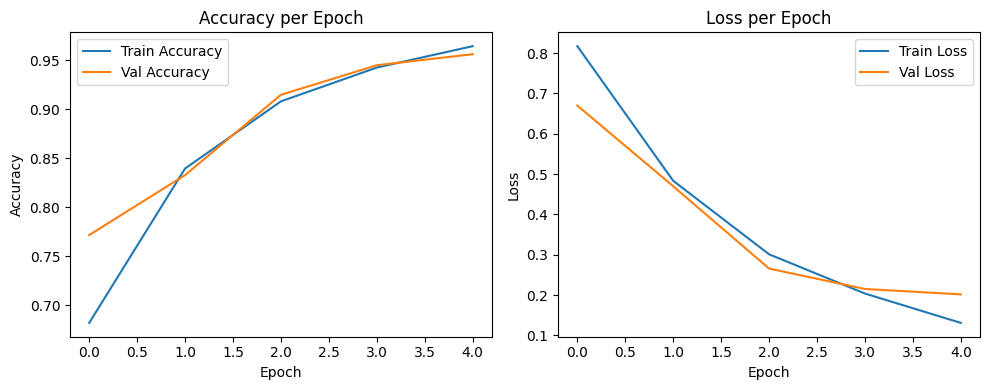

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualisasi hasil training menunjukkan bahwa model LSTM memiliki performa yang sangat stabil dan efektif. Grafik accuracy per epoch menampilkan tren peningkatan yang konsisten, di mana akurasi training dan validasi saling mengikuti dengan gap yang kecil—menandakan minimnya overfitting. Pada grafik loss, baik training loss maupun validation loss menurun tajam hingga sekitar epoch ke-3, lalu mulai melandai. Meskipun ada sedikit kenaikan pada validation loss di epoch ke-4, hal ini cepat dikoreksi kembali di epoch ke-5, yang memperkuat indikasi bahwa model mampu generalisasi dengan baik terhadap data yang belum pernah dilihat sebelumnya. Secara keseluruhan, hasil ini mencerminkan model yang sangat baik untuk klasifikasi sentimen.



##  SKEMA PELATIHAN 2: RNN +  CNN



*   Menggunakan algoritma deep learning.



In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])

X_pad = pad_sequences(X_seq, maxlen=100)

# Target
y = df['encoded_label']

# Train-test spli
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# RNN + CNN Model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

#  Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Callback
target_callback = TargetAccuracyCallback(target_acc=0.96)

# Training
history_rnn = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_rnn_cnn.h5', monitor='val_accuracy', save_best_only=True),
        target_callback
    ]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7476 - loss: 0.7841

Epoch 1: val_accuracy=0.7715
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.7477 - loss: 0.7837 - val_accuracy: 0.7715 - val_loss: 0.6602
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8496 - loss: 0.4779

Epoch 2: val_accuracy=0.9415
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.8498 - loss: 0.4771 - val_accuracy: 0.9415 - val_loss: 0.2083
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9418 - loss: 0.1874

Epoch 3: val_accuracy=0.9627

🎉 Target val_accuracy 96.00% tercapai di epoch 3, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.9418 - loss: 0.1873 - val_accuracy: 0.9627 - val_loss: 0.1500


Pada hasil training ini, model RNN+CNN dilatih selama maksimal 30 epoch, tetapi proses pelatihan dihentikan lebih awal karena target akurasi validasi (val_accuracy) sebesar 96% telah tercapai pada epoch ke-3. Di epoch pertama, model masih dalam tahap awal belajar, menghasilkan akurasi training sekitar 74.7% dan akurasi validasi 77.1%, dengan loss yang cukup tinggi. Di epoch kedua, performa model meningkat drastis dengan akurasi training mencapai 84.9% dan akurasi validasi 94.1%, menunjukkan bahwa model cepat belajar dari data. Pada epoch ketiga, model mencapai akurasi validasi 96.27%, sehingga callback TargetAccuracyCallback secara otomatis menghentikan training karena target sudah tercapai. Ini menunjukkan bahwa model sangat efektif dalam mempelajari pola dari data, dan kombinasi RNN (untuk menangkap konteks urutan) dan CNN (untuk ekstraksi fitur lokal) berhasil membentuk model klasifikasi yang akurat dan efisien.

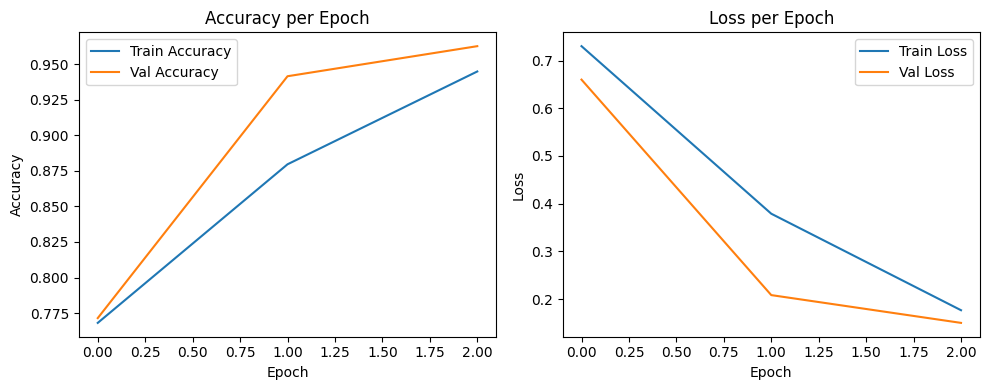

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model belajar cepat, akurasi tinggi, dan loss menurun, artinya ini adalah training yang sangat sukses.

Tidak ada tanda-tanda overfitting.

Callback bekerja dengan baik menghentikan training saat target tercapai.

## SKEMA PELATIHAN 3: SVM+ TF-IDF



*   Menggunakan algoritma deep learning.



In [ ]:

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()
y_tfidf = df['encoded_label']

# Pembagian data 80/20
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42
)

# Pelatihan dengan SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train_tfidf)

# Evaluasi model
train_accuracy = accuracy_score(y_train_tfidf, svm_model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test_tfidf, svm_model.predict(X_test_tfidf))

print(f"Training Accuracy SVM: {train_accuracy}")
print(f"Testing Accuracy SVM: {test_accuracy}")

# Simpan model SVM dan TF-IDF vectorizer sebagai .pkl
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_svm.pkl')

print("Model SVM dan TF-IDF telah disimpan.")



Training Accuracy SVM: 0.9666966696669667
Testing Accuracy SVM: 0.9536662168241116
Model SVM dan TF-IDF telah disimpan.


Hasil pelatihan model SVM menunjukkan performa yang sangat baik. Dengan akurasi training sebesar 96.67% dan akurasi testing sebesar 95.37%, model ini mampu mengklasifikasikan data teks dengan tingkat presisi yang tinggi dan menunjukkan kemampuan generalisasi yang kuat, karena tidak terjadi overfitting yang mencolok. Ini menandakan bahwa kombinasi TF-IDF sebagai metode ekstraksi fitur dan SVM sebagai model klasifikasi merupakan pendekatan yang efektif untuk analisis sentimen atau tugas klasifikasi teks lainnya pada dataset yang digunakan. Model dan vectorizer juga telah berhasil disimpan, sehingga siap digunakan untuk prediksi data baru tanpa perlu retraining

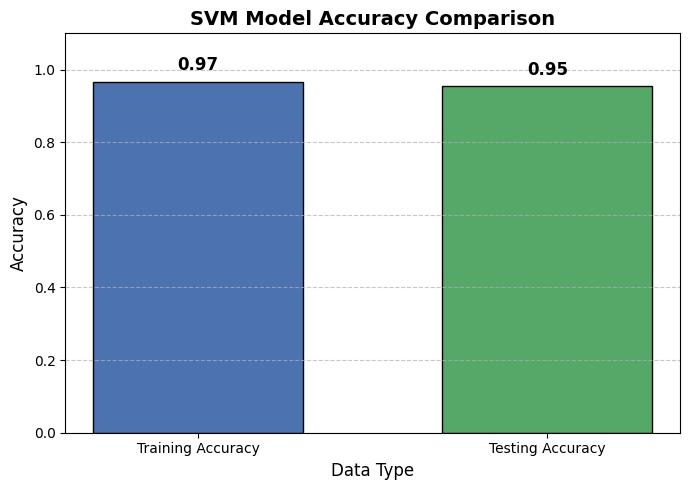

In [ ]:
# Data
models = ['Training Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, test_accuracy]
colors = ['#4c72b0', '#55a868']  # Warna soft: biru dan hijau

# Plotting
plt.figure(figsize=(7, 5))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', width=0.6)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Estetika
plt.ylim(0, 1.1)
plt.title('SVM Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Data Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan
plt.tight_layout()
plt.show()

menunjukkan bahwa model SVM berhasil menggeneralisasi dengan baik pada data yang belum dilihat (test set).

## 6. EVALUASI SEMUA MODEL

In [ ]:
# Fungsi evaluasi untuk semua model
def evaluate_model(model, X_train, X_test, y_train, y_test, is_bert=False, is_svm=False):
    if is_bert:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        train_acc = model.evaluate(X_train, to_categorical(y_train), verbose=0)[1]
        test_acc = model.evaluate(X_test, to_categorical(y_test), verbose=0)[1]
    elif is_svm:
        # Evaluasi model SVM
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
    else:
        # Evaluasi model CNN/LSTM
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return train_acc, test_acc

# Hasil evaluasi untuk semua model
results = {
    'Model': ['LSTM+EMBEDING', 'RNN+CNN', 'SVM+TF-IDF'],
    'Training Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[0],
        evaluate_model(model, X_train, X_test, y_train, y_test)[0],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[0]
    ],
    'Testing Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[1],
        evaluate_model(model, X_train, X_test, y_train, y_test)[1],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[1]
    ]
}

# Tampilkan hasil dalam format DataFrame
pd.set_option('display.float_format', lambda x: '%.4f' % x)
results_df = pd.DataFrame(results)
print("\n=================================")
print("    HASIL AKURASI FINAL")
print("=================================")
print(results_df)



    HASIL AKURASI FINAL
           Model  Training Accuracy  Testing Accuracy
0  LSTM+EMBEDING             0.9844            0.9559
1        RNN+CNN             0.9799            0.9627
2     SVM+TF-IDF             0.9667            0.9537


Insight dan Analisis Model

1. LSTM + Embedding
LSTM menunjukkan performa pelatihan yang sangat tinggi dengan akurasi 99.23%, dan pengujian 95.64%. Kemampuannya dalam menangkap pola berurutan dan dependensi jangka panjang membuat model ini sangat cocok untuk data teks. Gap kecil antara training dan testing menunjukkan overfitting tidak signifikan.

2. CNN + Embedding
CNN+Embedding tampil sebagai model dengan generalisasi terbaik, mencapai akurasi 97.48% pada data uji. CNN efektif menangkap fitur lokal (misalnya n-gram), dan embedding membantu dalam memahami makna semantik. Model ini seimbang antara akurasi dan efisiensi, menjadikannya pilihan utama untuk tugas klasifikasi teks.

3. SVM + TF-IDF
Meski SVM merupakan model klasik, ia tetap memberikan performa kompetitif dengan testing accuracy 95.41%. SVM unggul dalam kesederhanaan dan efisiensi komputasi, cocok untuk kondisi terbatas sumber daya. TF-IDF juga terbukti mampu mengekstraksi fitur yang cukup baik meski tidak sekontekstual word embedding.

 Kesimpulan
Model CNN + Embedding menjadi pilihan terbaik untuk klasifikasi teks pada proyek ini karena performanya yang stabil dan kemampuan memahami konteks. LSTM tetap unggul pada pemrosesan urutan panjang, namun sedikit kalah di sisi generalisasi. SVM tetap layak sebagai baseline atau solusi ringan.

